This is an [jupyter](http://jupyter.org) notebook.
Lectures about Python, useful both for beginners and experts, can be found at http://scipy-lectures.github.io.

Open the notebook by (1) copying this file into a directory, (2) in that directory typing 
jupyter-notebook
and (3) selecting the notebook.

# <font color= 'orange'> Poisson Image Editing</font>

## Seamless Image Cloning

***
 A notebook by ***Dhruv Ilesh Shah***
***

In this exercise, we will learn and implement Seamless Image Cloning by employing the Poisson Solver.

***Packages Used:*** Python 2.7, Numpy, Matplotlib, openCV 3.1.0,  `gimp 2.8` (recommended)

*openCV has been used only for Image importing purposes, and can be replaced by PIL as well. Similarly, Matplotlib has been used only for displaying results inline.*
***

### Motivation

Image cloning and morphing have been some of the most common purposes of Image Processing and editing. Most of us have used these tools at a very abstract level through packages like Photoshop or GIMP etc. But have you ever thought about what goes into actuating this process? Here we explain the math behind the idea and the algorithm for seamlessly cloning an image *(or a portion thereof)* onto another image. The dictionary defines ***seamless*** as *smooth and without seams or obvious joins* and hence our objective would be to make an image as smooth and natural as possible.

Soon after, we'll get our hands dirty by actually coding the algorithm and running it on a sample image to achieve the results for oursef. Towards the end, we will also look at the various parameters that can be tweaked to achieve better results.
***

### Understanding Seamless Cloning

Say you want to clone/morph a portion of image 1 onto a position on image 2. The simplest way to start off is to simply **paste** that portion of image on the other. But well, as you'd expect, the border has a very *sharp* change in features (known as gradient) and hence we can easily claim that the image is forged. What we need is a way to create a softer gradient, so that the image looks more natural.

![Seamless Cloning Example](images/seamless_cloning_ex.jpg)
<center> Courtesy: Vision @ Berkeley</center>

This image set represents one of the best output I've seen this algorithm generate. As you see above, the softening of edges can be employed to make the image look better and the texture of the cloned image is preserved giving an almost natural looking eagle in the blue sky (*Mesmerising, isn't it?*)! This is a common blendng style in many Image Editing tools. Our goal, in this notebook, is to implement a function that can do a similar task from scratch. *(Do note that a similar function already exists in openCV)*

At a very naive level, imagine the problem as solving the Laplace's Equation in 2 dimensions. The boundary of the cloned portion refer to the Boundary Conditions and you have to find a smooth curve fitting the conditions, such that no local extrema exist within the area, giving you a smooth image. This, at a basic level, is how the algorithm is evaluated. Now, let's get into the math behind the algorithm, and discretisation of the algorithm!
***

### The Math behind the Problem

It was well known to psychologists [Land and McCann 1971] that slow gradients of intensity, which are suppressed by the Laplacian operator, can be superimposed on an image with barely noticeable effect. Conversely, the second-order variations extracted by the Laplacian operator are the most significant perceptually.

Secondly, a *scalar* function on a bounded domain is uniquely defined by its values on the boundary and its Laplacian in the interior. The Poisson equation therefore has a unique solution and this leads to a sound algorithm.

So, given methods for crafting the Laplacian of an unknown function over some domain, and its boundary conditions, the Poisson equation can be solved numerically to achieve seamless filling of that domain. This can be replicated independently in each of the channels of a color image. Solving the Poisson equation also has an alternative interpretation as a minimization problem: it computes the function whose gradient is the closest, in the L2 -norm (*Google!*), to some prescribed vector field — the *guidance vector field* — under given boundary conditions. In that way, the reconstructed function interpolates the boundary conditions inwards, while following the spatial variations of the guidance field as closely as possible.

**Poisson Solution to *Guided Interpolation*: ** Interpolation, in the context of images, refers to being able to predict, and assign, values to an undefined pixel, given the surrounding values. It is one of the simplest ways to smoothen out an image and make it seamless. A good explanation on the topic can be found [here](https://prieuredesion.github.io/image%20processing/2016/05/15/interpolation.html). ![Guided Interpolation](images/guided_interpolation.png)

The above image gives a great idea of the task at hand. Note the terminologies, as it would be used later as well. ***g*** refers to the portion of the source image that goes ON the $\Omega$ portion of the destination image. ***v*** is the gradient field that defines features like texture and gradience in that portion. ***f*** is the symbol used to denote the cloned portion that will be processed.

The simplest interpolant f over Ω is the membrane interpolant defined as the solution of the minimization problem:

$$\min_f \int_{\infty}^{} |\nabla f|^2 \hspace{0.5cm} with \hspace{0.5cm} f|_{d\Omega} = f^*|_{d\Omega} $$
where $\nabla$ is the gradient operator. The minimisation problem mentioned above is more like solving the Laplace's equation ($\nabla^2 f = 0$) with no gradient field. In the presence of a gradient vector field, we define the problem as follows:
$$\min_f \int_{\infty}^{} |\nabla f - v|^2 \hspace{5mm} with \hspace{5mm} f|_{d\Omega} = f^*|_{d\Omega} $$

The nature of this *guidance field* defines the nature of cloning, and various other results can be obtained by only tweaking this ***v*** from this algorithm, keeping everything else the same. The algorithm works by solving the *Dirichlet Boundary Condition* in the region $d\Omega$, which is the boundary of the region $\Omega$. The algorithm used for solving is known as the ***Jacobi's Iterative Method***. 

*Understanding the complete math may require deep knowledge of PDEs and related problems, and it is fine if you can accept the concept intuitively. The next part, then, would make more sense and illustrate how all the math is implemented*.

### Employing the *Discrete* Poisson Solver

As you would already be wondering, solving an integral and minimising an expression directly is not very intuitive, for implementing in a code. Instead, we choose to *approximate* and discretise the expressions so that they make more sense.

For discrete images the problem can be discretized naturally using the underlying discrete pixel grid. Without loss of generality, we will keep the same notations for the continuous objects and their discrete counterparts: S, $\Omega$ now become finite point sets defined on an infinite discrete grid. Note that S can include all the pixels of an image or only a subset of them. For each pixel p in S, let $N_p$ be the set of its 4-connected neighbors which are in S, and let p, q denote a pixel pair such that q ∈ $N_p$. The boundary of Ω is now $d\Omega$ = {p ∈ S \ $\Omega : N_p \cap \Omega \neq \emptyset$}. Let $f_p$ be the value of f at p. The task is to compute the set of intensities $f|_\Omega = f_p, p \in \Omega $.

For Dirichlet Boundary Conditions, the finite difference discretisation yields the following quadratic optimisation problem.

$$ \min_{f|_\Omega} \sum_{\langle p,q\rangle\cap\Omega\neq\emptyset} (f_p-f_q-v_{pq})^2 \hspace{3mm} with \hspace{3mm} f_p=f_p^* \hspace{3mm} for\:all\:p \in d\Omega$$

Where $v_{pq}$ is the projection of $v(\frac{p+q}{2})$  on the oriented edge $[p,q]$ as seen in the continuous domain. To convert this in the discrete domain, we can think of it as the gradient field along the line joining pixels $p$ and $q$. It's solution satisfies the following simultaneous linear equations:

$$for\:all\:p \in \Omega,\,|N_p|f_p-\sum_{q\in N_p\cap\Omega}f_q\,=\,\sum_{q\in N_p\cap d\Omega}f_q^* + \sum_{q\in N_p}v_{pq}$$

Here, $|N_p|$ refers to the number of pixels in the neighbourhood of $p$ that also lie in $\Omega$, ie, the cardinality. The method of obtaining this relation from the above is non-trivial and requires significant background in Calculus and Differential Equations. For beginners, assume the above is given and try to tackle the problem intuitively. The equations above form a classical, [positive-definite system](http://www.math.usm.edu/lambers/mat610/sum10/lecture7.pdf). Since the boundary $d\Omega$ can be arbitrary, we must use well-known iterative solvers like the Gauss-Siedel iteration with successive overrelaxation.
***

### Let's tackle the problem in Layman's terms

This section is for you if (1) you have a slight idea of what is happening till now, and wish to understand further by using intuition, and (2) you have *no clue whatsoever* and wish to understand the algorithm.

Let us begin by simple Laplacian Solvers, ie, $\nabla^2 = 0$. skipping all the underlying math, you have probably been told that the function obtained does not have any maxima/minima in its interior and is a completely smooth shape. Converting this to the domain of *images*, let's look at the value of the function $f$ as it's pixel value in [0,255]. Clearly, given a boundary condition, the unique solution to Laplace's equation will result in smoothening of the interior and no sharp edges. This is what a boundary should look like if it is *seamless*.

*But wait!* You also know that given a B.C., Laplace's equation has a unique solution, and given enough time (read: iterations) it would be independent of the cloned image! *Alas!* Now what? How do we preserve the features of the original image, which are in fact more important that smoothening (what use is seamless, if there's no cloning :p ). Here's where the idea of a gradient field comes in. It preserves the gradient, ie, texture and modulation in features of the image. The real math was stated above, but intuitively, it decides the shape and texture of the smooth curve fitting in the region. The Laplace's Solver is now replaced by the Poisson Solver, and the gradient field drives the interior of the region. Depending on the gradient field, certain or all features of the cloned portion can be preserved and or highlighted.

The final outcome is decided by the choice of this gradient field. Next up is the simplest and optimal gradient field for Seamless Cloning. Towards the end, we will talk of other applications that can be achieved by changing this gradient field.

***

### Implementing Seamless Cloning

From the algorithm discussed in the earlier part, we see that the only missing information is the *gradient field **v***. The gradient field defines the features and textures of the image that we wish to introduce. Intuitively, what do you think would be an ideal gradient field for the region $\Omega$ in the current situation?

We have the source image portion in the region $\Omega$ and we wish to blend it with the destination image. An ideal choice of gradient field would be the gradient vector field of the source image itself! This way, we preserve the features of the portion that we want as the dominant feature in $\Omega$. We write this as:
$$ v = \nabla g $$
Thus, the governing conditions now become

$$ \Delta f = \Delta g\,\, over\:\:\Omega,\,with f|_{d\Omega}=f|_{d\Omega}^*$$

For the numerical (discrete) counterpart of the definition of gradient field, we have:

$$ v_{pq}=g_p-g_q,\:\, for\:all\:\langle p,q \rangle $$


The seamless cloning tool thus obtained ensures the compliance of source and destination boundaries. It can be used to conceal undesirable image features or to insert new elements in an image, but with much more flexibility and ease than with conventional cloning. We will now implement this algorithm on Python.
***

## <font color="blue"> Let's get Coding!!! </font>

Firstly, we import all necessary packages. All the packages can be downloaded using `pip`. As an alternative to openCV, you can use PIL as well. Refer to the [readme](README.md) for more details.

In [1]:
%matplotlib inline 

import cv2
import numpy as np
import matplotlib.pyplot as plt

For applying the algorithm, you will need the cloned image and a mask that identifies the cloned portion of the image. The purpose of the mask will become clear in the subsequent steps.  
***How to obtain the mask?*** *This method needs improvement - suggestions welcome!*
* Given that you clone the image on your system, I recommend you use `gimp` for the purpose. Open `GIMP Image Editor`.
* Open the image on which cloning must occur, the destination image.
* In another window, open the source, whose portion is to be cloned. Using the select tool, select and copy the portion.
* Paste the portion on the destination image. You will see that a new layer with the pasted portion will be created. Using the `Transform` tool, move the portion to desired location and scale accordingly, using the `Scale` tool.
* Export this image and save your cloned file as a `jpeg` or `png` file. Now we must make the mask.
* Create a new `background layer` and place it below the pasted layer. Also, hide the destination image layer. Select the bg-layer and color it black using the Color Tool.
* You will now have the cloned portion on a black background. Using the Thresholding tool (or on `cv2`), threshold all pixels above 1 as 255.(*This should work unless your image has a pixel value 0, in which case you may have to use floodFill or explicitly modify the mask file*).
* Export this file as the mask image in the `jpeg` or `png` format.

Let's now begin with the algorithm implementation.

In [2]:
im_cloned = cv2.imread("stinkbug_cloned.png",  cv2.IMREAD_GRAYSCALE)
im_mask = cv2.imread("stinkbug_cloned_mask.png", cv2.IMREAD_GRAYSCALE)
it = 200; # Set number of iterations

After importing the image and mask, we create a temporary image to store the current value of pixels as the new ones are being calculated. This is because we want to simultaneously update values. * The iterative method used is called the ** Jacobi's Method. ** * In contrast to this, the ***Gauss-Siedel method*** involves no temporary matrix and the update occurs along with the code. This converges faster, but may result in loss of information and unexpected outcomes in some cases.

In [4]:
im_temp = im_cloned.copy()
im_seamless = im_temp.copy()
sigma = []
for i in range(im_cloned.shape[0]):
        for j in range(im_cloned.shape[1]):
            if (im_mask[i,j]==255):
                sigma.append([i,j])

for a in range(it):
    for [i,j] in sigma:
        term = 10000
        term = term + im_seamless[i+1, j]+im_seamless[i-1, j]+im_seamless[i, j-1]+im_seamless[i, j+1]
        if(im_mask[i-1, j]==255):
            term = term + im_cloned[i,j]-im_cloned[i-1,j]
        if(im_mask[i+1, j]==255):
            term = term + im_cloned[i,j]-im_cloned[i+1,j]
        if(im_mask[i, j+1]==255):
            term = term + im_cloned[i,j]-im_cloned[i,j+1]
        if(im_mask[i, j-1]==255):
            term = term + im_cloned[i,j]-im_cloned[i,j-1]
        im_temp[i,j] = (term-10000)/4
    im_seamless = im_temp.copy()
    if a%50==0:
        print a

0
50
100
150


As is visible from the code, we scan the whole cloned image for points where the corresponding value of the mask is 255 (*white*), and update `im_temp` as suggested in the algorithm. The gradient for the source image is defined as zero at the boundary points.
*Note that the pixel values in cv2 are of `ubyte_scalar` type and hence don't support addition due to overflow. `10000` is a random large number that helps maintain the variable `term` as a normal integer and hence allow addition without overflow*

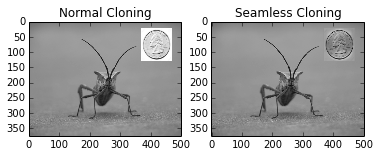

In [5]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_cloned,cmap = 'gray')
ax[0].set_title('Normal Cloning')
ax[1].imshow(im_seamless, cmap='gray')
ax[1].set_title('Seamless Cloning')

As you can see, the images have blended pretty well, with features of source image preserved, and the cloning almost seamless! To view the image in a separate window, execute the next cell.

**Note: ** The above implementation has been made only in one channel (*grayscale*), but running the same algorithm in the three different channels will give similar results for RGB/HSV/CIE-Lab schemes.

In [6]:
cv2.imshow("Naive Cloning", im_cloned)
cv2.imshow("Seamless Cloning", im_seamless)
cv2.waitKey(0); cv2.destroyAllWindows()

### What Comes Next?

Having understood the algorithm and implementation, it shouldn't be tough to experiment with the parameter **it** and identify an optimal figure depending on the size of $\Omega$. Also, you can try vectorising some potions which haven't been done so yet and improve runtime.

Also, by gently changing the *gradient field* we can obtain several desirable effects - Mixing Gradients, Feature Exchange, Inserting Transparent Objects, Texture Flattening - the list is endless. Google is your friend here, and so is [this paper](https://www.cs.jhu.edu/~misha/Fall07/Papers/Perez03.pdf). Good luck exploring the topic! There's so much more to do... All you'd need is the will to do it!

*Cheers!*

#### Thank You!
***